In [1]:
import scipy.io
import numpy as np
from collections import defaultdict
from scipy.sparse import dok_matrix

In [2]:
def findMaxIndex(mat, maxLength=None):
    size = 0
    for nset in mat['nodeSet'][0]:
        if maxLength:
            size = max(maxLength+1, size)
        else:
            size = max(np.max(nset.flatten())+1, size)
    return size

def convertToCluster(mat, maxLength=None):
    # label 0 are nodes ioslated or label paddings
    size = findMaxIndex(mat, maxLength)
    clusters = np.zeros(size)
    label = 1
    for nset in mat['nodeSet'][0]:
        clusters[nset.flatten()] = label
        label += 1
    return clusters

In [38]:
import os
out_dir = 'composite_cluster_outputs_all_85/'

clusters = []
for file in os.listdir(out_dir):
    if not file.endswith('mat'): continue
    path = out_dir + file
    mat = scipy.io.loadmat(path)
    clusters.append(convertToCluster(mat, maxLength=5245))
lables = np.array(clusters)
# np.save('composite_cluster_all_85', labels)
labels, labels.shape

array([[ 0.,  1.,  0., ..., 11.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       [ 0., 10.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ..., 10.,  0.,  0.]])

In [42]:
def createLabelVector(labels):
    mruns, nsamples = labels.shape
    return [tuple(labels[:,i]) for i in range(nsamples)]

In [43]:
def countLabelVector(labelVectors):
    lv_dict = defaultdict(int)
    for lv in labelVectors:
        lv_dict[lv] += 1
    return lv_dict

In [44]:
def computeHammingDistance(t1, t2):
    return sum([t1[i] != t2[i] for i in range(len(t1))])

In [45]:
def most_common(lst):
    return int(max(((item, lst.count(item)) for item in set(lst)), key=lambda a: a[1])[0])

In [70]:
# create edges between label vector if the hamming distance is smaller than a threshold
# the weight of the edge is scaled to ampify the hamming distance effect
def createEdges(keys, dist=10, scaling=-10.0):
    n = len(keys)
    dokmat = dok_matrix((n, n))
    for i in range(n):
        for j in range(i+1, n):
            if (computeHammingDistance(keys[i], keys[j]) <= dist):
                dokmat[i,j] = np.exp((computeHammingDistance(keys[i], keys[j])-1)/scaling)
    return dokmat.tocoo()

# load existing label vectors

In [5]:
labels = np.load('composite_cluster_all_85.npy')
labels = labels.astype(int)
labels.shape

(20, 5246)

In [17]:
# labels = np.load('composite_cluster_outputs_CINMS_80.npy')
# labels = labels.astype(int)
# labels.shape

(500, 3845)

In [73]:
# row iterations, column samples
labels.shape

(108, 5246)

In [72]:
labels

array([[ 0.,  1.,  0., ..., 11.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       [ 0., 10.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ..., 10.,  0.,  0.]])

In [74]:
# how many different clusters do Kait's clustering algorithm give us each time?
counts = np.sort(labels,axis=1)
(counts[:,1:] != counts[:,:-1]).sum(axis=1)+1

array([14, 14, 13, 15, 14, 13, 15, 14, 14, 14, 14, 14, 15, 15, 15, 14, 14,
       14, 15, 15, 14, 14, 15, 14, 15, 14, 15, 15, 15, 14, 15, 15, 14, 15,
       14, 15, 15, 15, 13, 15, 15, 14, 14, 14, 14, 15, 14, 14, 15, 15, 12,
       14, 16, 14, 14, 13, 14, 15, 15, 15, 14, 15, 15, 15, 14, 15, 14, 14,
       15, 14, 13, 13, 15, 15, 14, 15, 12, 14, 15, 15, 15, 15, 14, 15, 13,
       15, 15, 13, 15, 15, 14, 14, 15, 15, 15, 14, 15, 15, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 15])

In [56]:
# 0s are paddings or without actual meaning
lv_dict = countLabelVector(createLabelVector(labels))
keys = list(lv_dict)
keys = list(filter(lambda key: most_common(key) != 0, keys))
len(keys)

32

In [65]:
coomat = createEdges(keys, dist=100)

In [66]:
nodes = []
for i, key in enumerate(keys):
    nodes.append({'id': i, 
                  'r': lv_dict[key],
                  'group': most_common(key)
                 })
links = []
for i, j, v in zip(coomat.row, coomat.col, coomat.data):
    links.append({'source': int(i), 
                  'target': int(j),
                  'weight': v*10,
                 })

In [67]:
import json
with open('nodes.json', 'w') as f:
    json.dump(nodes, f)
with open('links.json', 'w') as f:
    json.dump(links, f)

Use the saved json files to visualize the effects:

https://observablehq.com/@jingwu010/force-directed-graph

In [68]:
links

[{'source': 0, 'target': 1, 'weight': 0.0012340980408667955},
 {'source': 0, 'target': 2, 'weight': 10.0},
 {'source': 0, 'target': 3, 'weight': 10.0},
 {'source': 0, 'target': 4, 'weight': 0.001507330750954765},
 {'source': 0, 'target': 9, 'weight': 1.224564282529819},
 {'source': 0, 'target': 12, 'weight': 10.0},
 {'source': 0, 'target': 18, 'weight': 0.0006128349505322213},
 {'source': 0, 'target': 19, 'weight': 0.0030353913807886677},
 {'source': 0, 'target': 20, 'weight': 6.065306597126334},
 {'source': 0, 'target': 22, 'weight': 0.0012340980408667955},
 {'source': 0, 'target': 27, 'weight': 10.0},
 {'source': 0, 'target': 28, 'weight': 0.0008272406555663223},
 {'source': 1, 'target': 2, 'weight': 0.001363889264820114},
 {'source': 1, 'target': 3, 'weight': 0.0012340980408667955},
 {'source': 1, 'target': 4, 'weight': 9.048374180359595},
 {'source': 1, 'target': 9, 'weight': 0.0007485182988770059},
 {'source': 1, 'target': 12, 'weight': 0.0012340980408667955},
 {'source': 1, 'targ

In [36]:
nodes

[{'id': 0, 'r': 282, 'group': 2},
 {'id': 1, 'r': 53, 'group': 1},
 {'id': 2, 'r': 3, 'group': 2},
 {'id': 3, 'r': 249, 'group': 2},
 {'id': 4, 'r': 7, 'group': 1},
 {'id': 5, 'r': 2854, 'group': 4},
 {'id': 6, 'r': 71, 'group': 2},
 {'id': 7, 'r': 24, 'group': 9},
 {'id': 8, 'r': 184, 'group': 5},
 {'id': 9, 'r': 6, 'group': 2},
 {'id': 10, 'r': 100, 'group': 9},
 {'id': 11, 'r': 113, 'group': 7},
 {'id': 12, 'r': 1, 'group': 2},
 {'id': 13, 'r': 125, 'group': 6},
 {'id': 14, 'r': 1, 'group': 4},
 {'id': 15, 'r': 267, 'group': 11},
 {'id': 16, 'r': 1, 'group': 11},
 {'id': 17, 'r': 1, 'group': 1},
 {'id': 18, 'r': 2, 'group': 2},
 {'id': 19, 'r': 178, 'group': 8},
 {'id': 20, 'r': 1, 'group': 1},
 {'id': 21, 'r': 26, 'group': 10},
 {'id': 22, 'r': 33, 'group': 13},
 {'id': 23, 'r': 84, 'group': 12},
 {'id': 24, 'r': 12, 'group': 2},
 {'id': 25, 'r': 2, 'group': 12},
 {'id': 26, 'r': 3, 'group': 8},
 {'id': 27, 'r': 2, 'group': 5},
 {'id': 28, 'r': 3, 'group': 8}]

In [51]:
hamming_distances = []
n = len(keys)
for i in range(n):
    for j in range(i, n):
        hamming_distances.append(computeHammingDistance(keys[i], keys[j]))

In [52]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


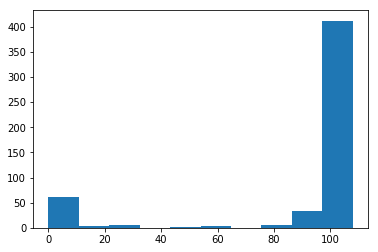

In [54]:
hist(hamming_distances);